In [1]:
import numpy as np  # For mathematical operations
import matplotlib.pyplot as plt # For plotting
import seaborn as sns # For plotting 
import pandas as pd    # For data handling
import plotly.express as px


# Reading data
raw_df = pd.read_csv('https://raw.githubusercontent.com/edv1hu/test/main/data(1).csv')
sns.set(style="darkgrid", font_scale=1.5)

In [2]:
outliers = raw_df.loc[(raw_df.Tp >30)].copy()
df = raw_df.drop(outliers.index)

In [4]:
functional_relationship = {
    'P' : ['n', 'Trip_no', 'Tp', 'Hs', 'wave_dir','wind_V_long', 'wind_V_trans'],
    'V' : ['n', 'Trip_no', 'Tp', 'Hs', 'wave_dir','wind_V_long', 'wind_V_trans'],
    'added_r'   : ['Tp', 'Hs', 'wave_dir','wind_V_long', 'wind_V_trans'],
    'calm_r'    : ['n', 'Trip_no'],
    'tot_r'     : ['n', 'Trip_no', 'Tp', 'Hs', 'wave_dir','wind_V_long', 'wind_V_trans']
}

In [5]:
# Dividing test, validation and training set based on the trip numbers
testSamps = df[(df['Trip_no'] == 3) | (df['Trip_no'] == 9)].index.to_numpy()
validSamps = df[df['Trip_no'] == 7].index.to_numpy()
trainSamps = np.setxor1d(df.index.to_numpy(), np.union1d(testSamps, validSamps))

test_df  = df.loc[testSamps].copy()
valid_df = df.loc[validSamps].copy()
train_df = df.loc[trainSamps].copy()

print('Data division ratio (training : validation : test) = (%.3f : %.3f : %.3f)' % (len(train_df)/len(df), len(valid_df)/len(df), len(test_df)/len(df)))

Data division ratio (training : validation : test) = (0.679 : 0.107 : 0.214)


In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers

In [7]:
def standardization(df_train, df_val, df_test):
    mean = df_train.mean()
    sigma = df_train.std() 
    std_df_train = (df_train - mean)/ sigma
    std_df_val = (df_val - mean)/ sigma
    std_df_test = (df_test - mean)/ sigma
    return std_df_train, std_df_val, std_df_test

std_df_train, std_df_val, std_df_test = standardization(train_df, valid_df, test_df)

In [8]:
def split_df_to_XY(df_train, df_val, df_test, var_y, var_x):
    X_train = df_train[var_x]
    y_train = df_train[var_y]
    X_val = df_val[var_x]
    y_val = df_val[var_y]
    X_test = df_test[var_x]
    y_test = df_test[var_y]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [9]:
def lin_reg_models(functional_relationship, std_df_train, std_df_val, std_df_test):
    models = []
    for yVar, xVar in functional_relationship.items():
        X_train, y_train, _, _, _, _ = split_df_to_XY(std_df_train, std_df_val, std_df_test, yVar, xVar)

        # Create linear regression object
        model = LinearRegression()
        model.fit(X_train, y_train)
        models.append(model)
    return models

models = lin_reg_models(functional_relationship, std_df_train, std_df_val, std_df_test)

In [10]:
def make_predictions(model, X_train, X_val, X_test, y_train, y_val, y_test):
    '''
    Predicts the target values using a linear regression model.
    returns: dataframes with prediced values and the correct indexes
    '''

    y_train_pred = pd.DataFrame(model.predict(X_train), index=y_train.index)
    y_val_pred = pd.DataFrame(model.predict(X_val), index=y_val.index)
    y_test_pred = pd.DataFrame(model.predict(X_test), index=y_test.index)

    return y_train_pred, y_val_pred, y_test_pred


def calculate_scores(y_true, y_pred):
    '''
    Calculates the R2 score, RMSE, and MAE between the true and predicted target values.

    Parameters:
    y_true (array-like): the true target values.
    y_pred (array-like): the predicted target values.

    Returns:
    r2 (float): the R2 score.
    rmse (float): the root mean squared error.
    mae (float): the mean absolute error.
    '''
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    residuals = y_true - y_pred
    return r2, rmse, mae, residuals




def plot_predictions(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, ax, i):
    '''
    Plots the true target values against the predicted target values for the training,
    validation, and test sets.

    Parameters:
    y_train (array-like): the true target values for the training set.
    y_train_pred (array-like): the predicted target values for the training set.
    y_val (array-like): the true target values for the validation set.
    y_val_pred (array-like): the predicted target values for the validation set.
    y_test (array-like): the true target values for the test set.
    y_test_pred (array-like): the predicted target values for the test set.
    ax (Matplotlib Axes): the Axes on which to plot the data.
    col (int): the column index of the Axes.
    row (int): the row index of the Axes.

    Returns:
    None (displays the plot).
    '''

    # Training set
    sns.scatterplot(x=y_train, y=y_train_pred[0], marker='.', color='blue', label='Training', ax=ax[i])

    # Validation set
    sns.scatterplot(x=y_val, y=y_val_pred[0], marker='.', color='orange', label='Validation', ax=ax[i])

    # Test set
    sns.scatterplot(x=y_test, y=y_test_pred[0], marker='.', color='red', label='Test', ax=ax[i])

    # Add diagonal line
    ax[i].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
    
    ax[i].set(title=y_test.name)
    ax[i].set_xlabel('True Values')
    ax[i].set_ylabel('Predictions')
    ax[i].legend(loc='upper left')
    

def plot_timeseries_pred(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, ax, i):
    
    # Real timeseries
    sns.scatterplot(data=y_train, marker='.', color='grey',edgecolor='whitesmoke',label='Real timeseries', ax=ax[i])
    sns.scatterplot(data=y_val, marker='.', color='grey',edgecolor='whitesmoke', ax=ax[i])
    sns.scatterplot(data=y_test, marker='.', color='grey',edgecolor='whitesmoke', ax=ax[i])

    # Training set
    sns.scatterplot(data=y_train_pred[0], marker='.', color='blue',edgecolor='lightsteelblue', label='Training', ax=ax[i])

    # Validation set
    sns.scatterplot(data=y_val_pred[0], color='orange',edgecolor='bisque', marker='.', label='Validation', ax=ax[i])

    # Test set
    sns.scatterplot( data=y_test_pred[0], marker='.', color='r',edgecolor='lightcoral', label='Test', ax=ax[i])

    ax[i].set(title=y_test.name)
    ax[i].set_xlabel('')
    ax[i].set_ylabel(y_train.name)
    ax[i].legend(loc='upper left')
    


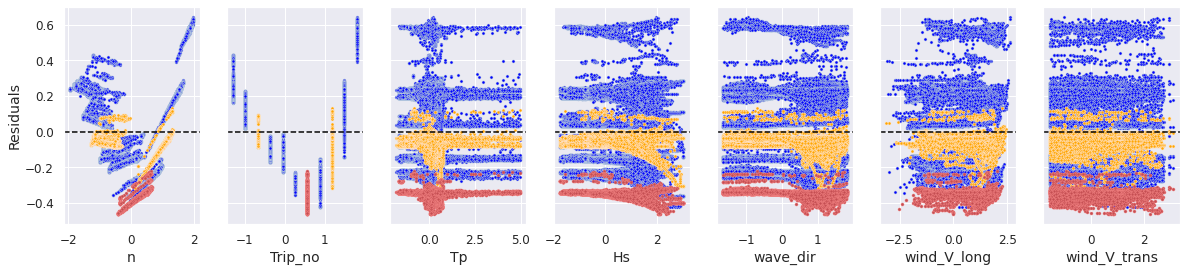

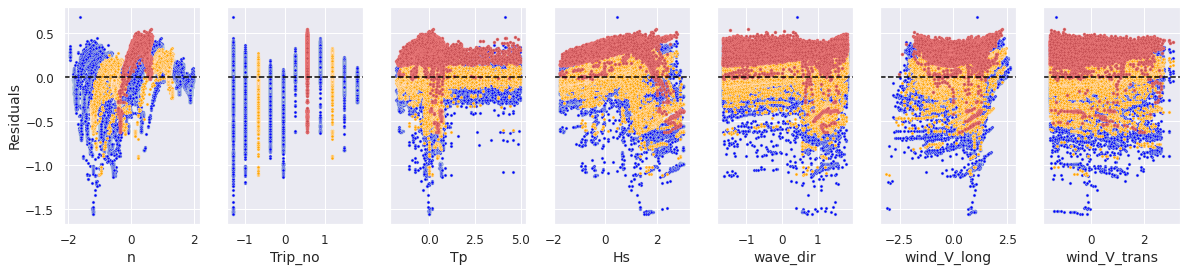

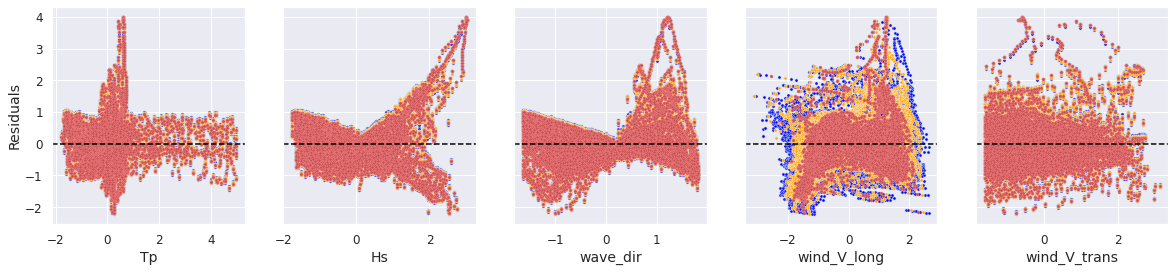

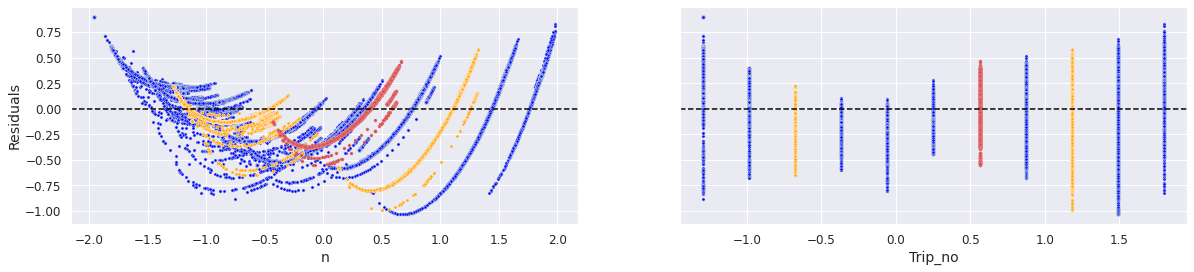

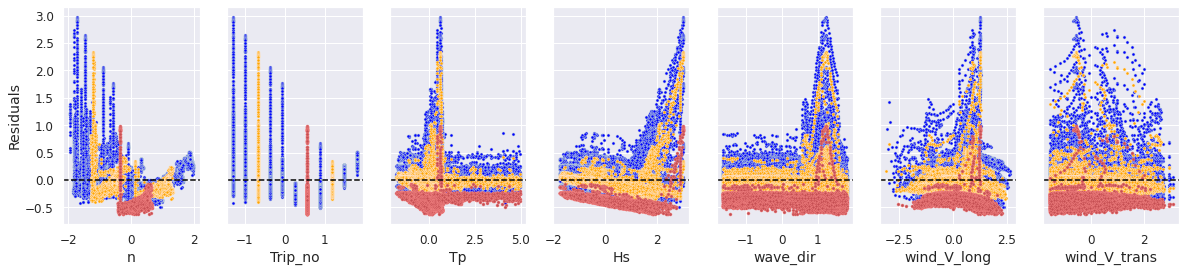

In [11]:
def plot_residuals(models, functional_relationship, std_df_train, std_df_val, std_df_test):
    
    for i, ((yVar, xVar), model) in enumerate(zip(functional_relationship.items(),models)):
        
        X_train, y_train, X_val, y_val, X_test, y_test = split_df_to_XY(std_df_train, std_df_val, std_df_test, yVar, xVar)
        y_train_pred, y_val_pred, y_test_pred = make_predictions(model, X_train, X_val, X_test, y_train, y_val, y_test)

        residuals_train = y_train - y_train_pred[0]
        residuals_val = y_val - y_val_pred[0]
        residuals_test = y_test - y_test_pred[0]


        # Create a figure with one row and a number of columns equal to the number of features
        fig, axs = plt.subplots(ncols=len(X_train.columns), figsize=(20, 4), sharey=True)

        # Plot residuals against each variable in a separate subplot
        for j, column in enumerate(X_train.columns):
            sns.scatterplot(x=X_train[column], y=residuals_train, marker='.', color='blue', edgecolor='lightsteelblue', ax=axs[j])
            sns.scatterplot(x=X_val[column], y=residuals_val, marker='.', color='orange', edgecolor='bisque', ax=axs[j])
            sns.scatterplot(x=X_test[column], y=residuals_test, marker='.', color='r', edgecolor='lightcoral', ax=axs[j])
            axs[j].axhline(y=0, linestyle='--', color='black')
            axs[j].set_xlabel(column, fontsize=14)
            axs[j].set_ylabel('Residuals', fontsize=14)
            axs[j].tick_params(labelsize=12)

        # Adjust subplot spacing and show the plot
        plt.show()

plot_residuals(models, functional_relationship, std_df_train, std_df_test, std_df_val)

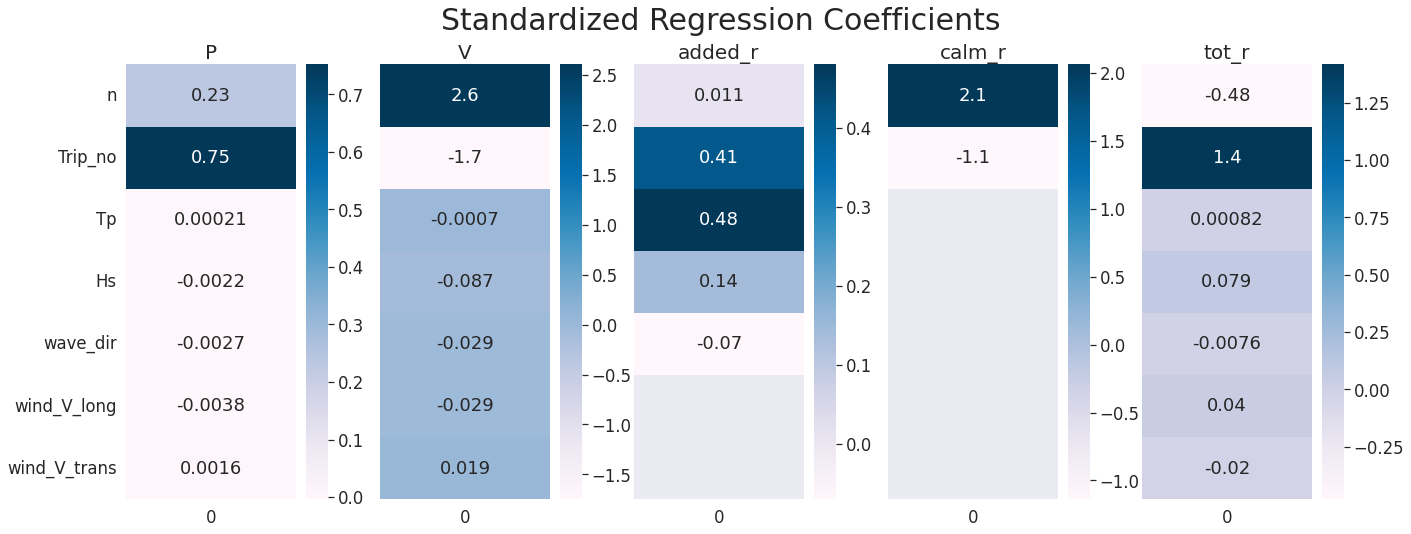

In [12]:

def std_reg_coef(models, std_df_train, std_df_val, std_df_test, functional_relationship):

    fig, axes = plt.subplots(nrows=1, ncols=len(functional_relationship), figsize=(22, 8), sharey=True, sharex=True)
    fig.suptitle('Standardized Regression Coefficients', fontsize=30)
    for i, ((yVar, xVar), model) in enumerate(zip(functional_relationship.items(),models)):
        X_train, y_train, X_val, y_val, X_test, y_test = split_df_to_XY(std_df_train, std_df_val, std_df_test, yVar, xVar)

        # Get the standardized regression coefficients
        std_coef = model.coef_ / np.std(X_train, axis=0)

        # Create a heatmap of the coefficients
        sns.heatmap(pd.DataFrame(std_coef, index=X_train.columns), cmap='PuBu', annot=True, ax=axes[i])
        axes[i].set_title(yVar, fontsize=20)

    plt.show()

std_reg_coef(models, std_df_train, std_df_val, std_df_test, functional_relationship)

In [ ]:
def MLP_models(functional_relationship, std_df_train, std_df_val, std_df_test):
    models = []
    for (yVar, xVar) in functional_relationship.items():

        X_train, y_train, X_val, y_val, X_test, y_test = split_df_to_XY(std_df_train, std_df_val, std_df_test, yVar, xVar)

        # Train an MLP model
        model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', verbose=1, batch_size=int(0.05 * len(X_train)))
        model.fit(X_train, y_train)
        
        models.append(model)
    
    return models

models_MLP = MLP_models(functional_relationship, std_df_train, std_df_val, std_df_test)

Iteration 1, loss = 0.23924013
Iteration 2, loss = 0.04886163
Iteration 3, loss = 0.02610914
Iteration 4, loss = 0.01770732
Iteration 5, loss = 0.01295384
Iteration 6, loss = 0.00987810
Iteration 7, loss = 0.00791888
Iteration 8, loss = 0.00653173
Iteration 9, loss = 0.00557326
Iteration 10, loss = 0.00491241
Iteration 11, loss = 0.00436864
Iteration 12, loss = 0.00394676
Iteration 13, loss = 0.00360361
Iteration 14, loss = 0.00330989
Iteration 15, loss = 0.00307047
Iteration 16, loss = 0.00283646
Iteration 17, loss = 0.00263169
Iteration 18, loss = 0.00245957
Iteration 19, loss = 0.00227933
Iteration 20, loss = 0.00214691
Iteration 21, loss = 0.00200525
Iteration 22, loss = 0.00186922
Iteration 23, loss = 0.00175178
Iteration 24, loss = 0.00169375
Iteration 25, loss = 0.00157556
Iteration 26, loss = 0.00145689
Iteration 27, loss = 0.00137306
Iteration 28, loss = 0.00130379
Iteration 29, loss = 0.00123515
Iteration 30, loss = 0.00117307
Iteration 31, loss = 0.00112343
Iteration 32, los

KeyboardInterrupt: KeyboardInterrupt: interrupted by user

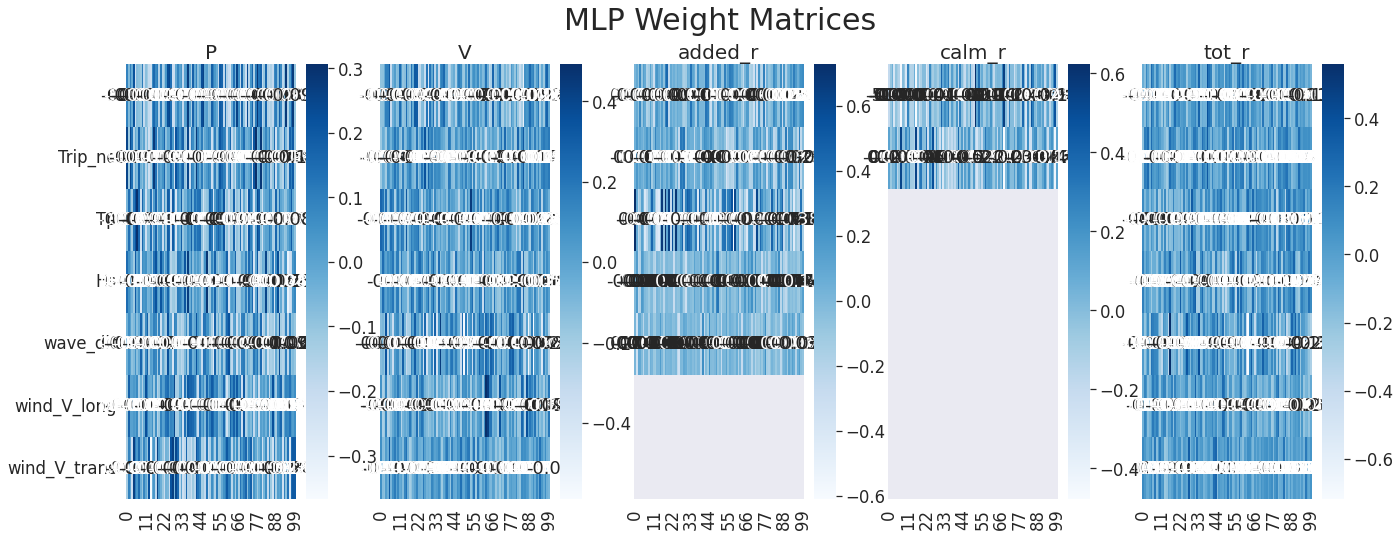

In [ ]:
def plot_mlp_weight_matrix(models, std_df_train, std_df_val, std_df_test, functional_relationship):
    fig, axes = plt.subplots(nrows=1, ncols=len(functional_relationship), figsize=(22, 8), sharey=True, sharex=True)
    fig.suptitle('MLP Weight Matrices', fontsize=30)
    for i, ((yVar, xVar), model) in enumerate(zip(functional_relationship.items(),models)):
        X_train, y_train, X_val, y_val, X_test, y_test = split_df_to_XY(std_df_train, std_df_val, std_df_test, yVar, xVar)

        # Get the weight matrix between input layer and first hidden layer
        weight_matrix = model.coefs_[0]  # shape: (n_features, n_hidden)

        # Create a heatmap of the weight matrix
        sns.heatmap(pd.DataFrame(weight_matrix, index=X_train.columns), cmap='Blues', annot=True, ax=axes[i])
        axes[i].set_title(yVar, fontsize=20)

    plt.show()
plot_mlp_weight_matrix(models_MLP, std_df_train, std_df_val, std_df_test, functional_relationship)

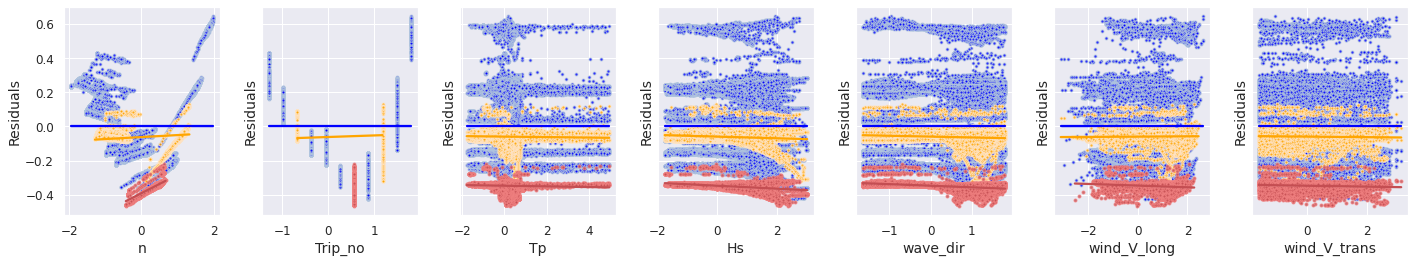

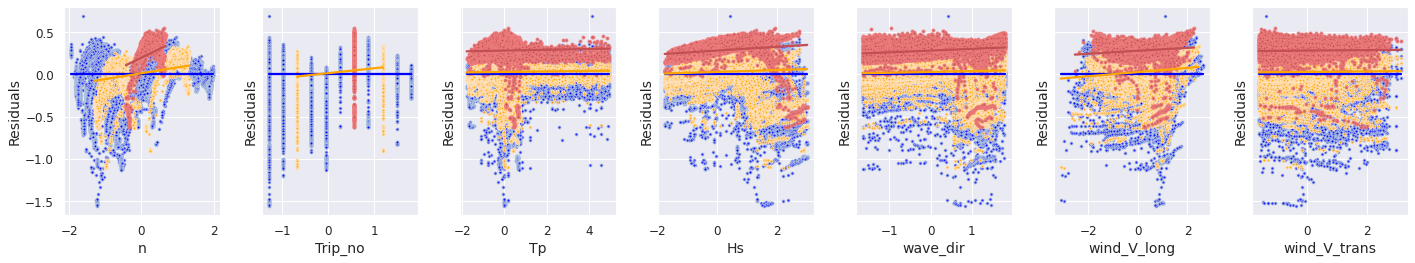

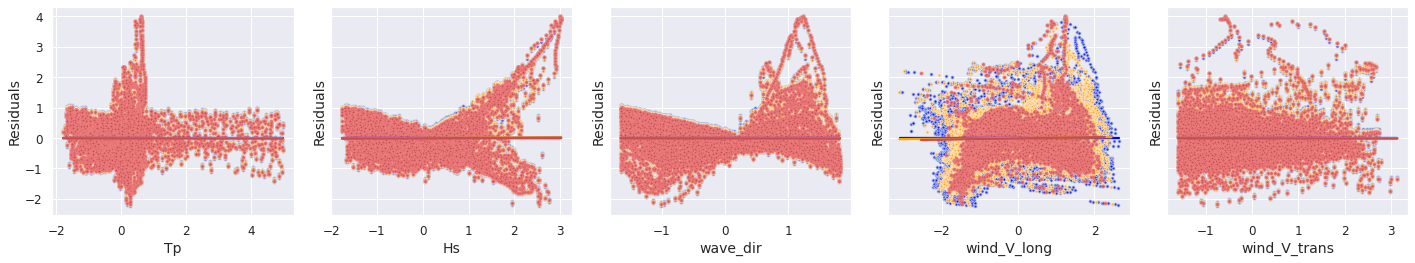

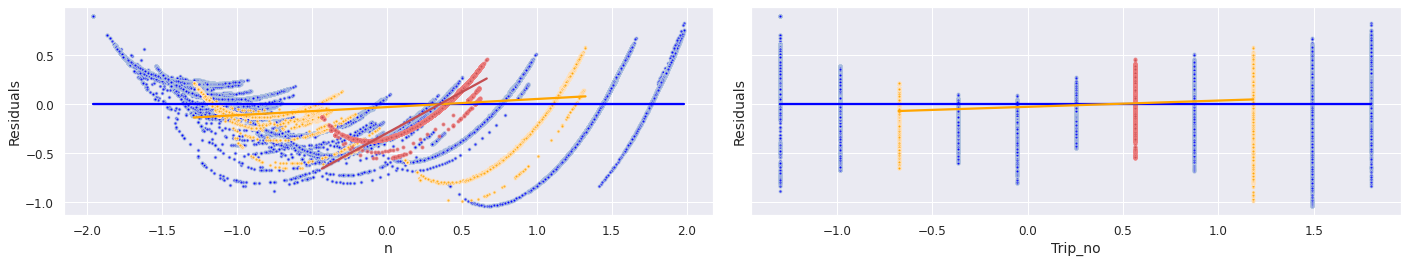

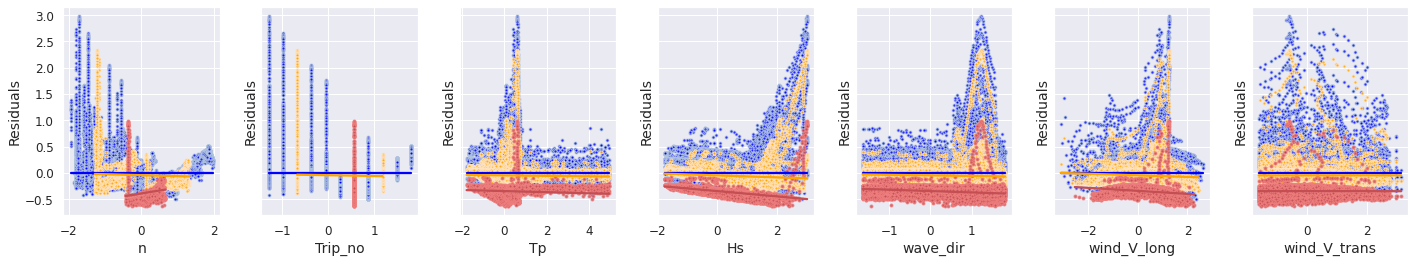

In [ ]:
import seaborn as sns

def plot_residuals(models, functional_relationship, std_df_train, std_df_val, std_df_test):
    
    for i, ((yVar, xVar), model) in enumerate(zip(functional_relationship.items(),models)):
        
        X_train, y_train, X_val, y_val, X_test, y_test = split_df_to_XY(std_df_train, std_df_val, std_df_test, yVar, xVar)
        y_train_pred, y_val_pred, y_test_pred = make_predictions(model, X_train, X_val, X_test, y_train, y_val, y_test)

        residuals_train = y_train - y_train_pred[0]
        residuals_val = y_val - y_val_pred[0]
        residuals_test = y_test - y_test_pred[0]


        # Create a figure with one row and a number of columns equal to the number of features
        fig, axs = plt.subplots(ncols=len(X_train.columns), figsize=(20, 4), sharey=True)

        # Plot residuals against each variable in a separate subplot
        for j, column in enumerate(X_train.columns):
            sns.regplot(x=X_train[column], y=residuals_train, marker='.', color='blue', scatter_kws={'edgecolor': 'lightsteelblue'}, ci=95, ax=axs[j])
            sns.regplot(x=X_val[column], y=residuals_val, marker='.', color='orange', scatter_kws={'edgecolor': 'bisque'}, ci=95, ax=axs[j])
            sns.regplot(x=X_test[column], y=residuals_test, marker='.', color='r', scatter_kws={'edgecolor': 'lightcoral'}, ci=95, ax=axs[j])
            axs[j].set_xlabel(column, fontsize=14)
            axs[j].set_ylabel('Residuals', fontsize=14)
            axs[j].tick_params(labelsize=12)

        # Adjust subplot spacing and show the plot
        plt.tight_layout()
        plt.show()
        
plot_residuals(models, functional_relationship, std_df_train, std_df_test, std_df_val)